# TASK 1: PROJECT OVERVIEW - AUTOMATING DATA SCIENCE WITH CREWAI AGENTS

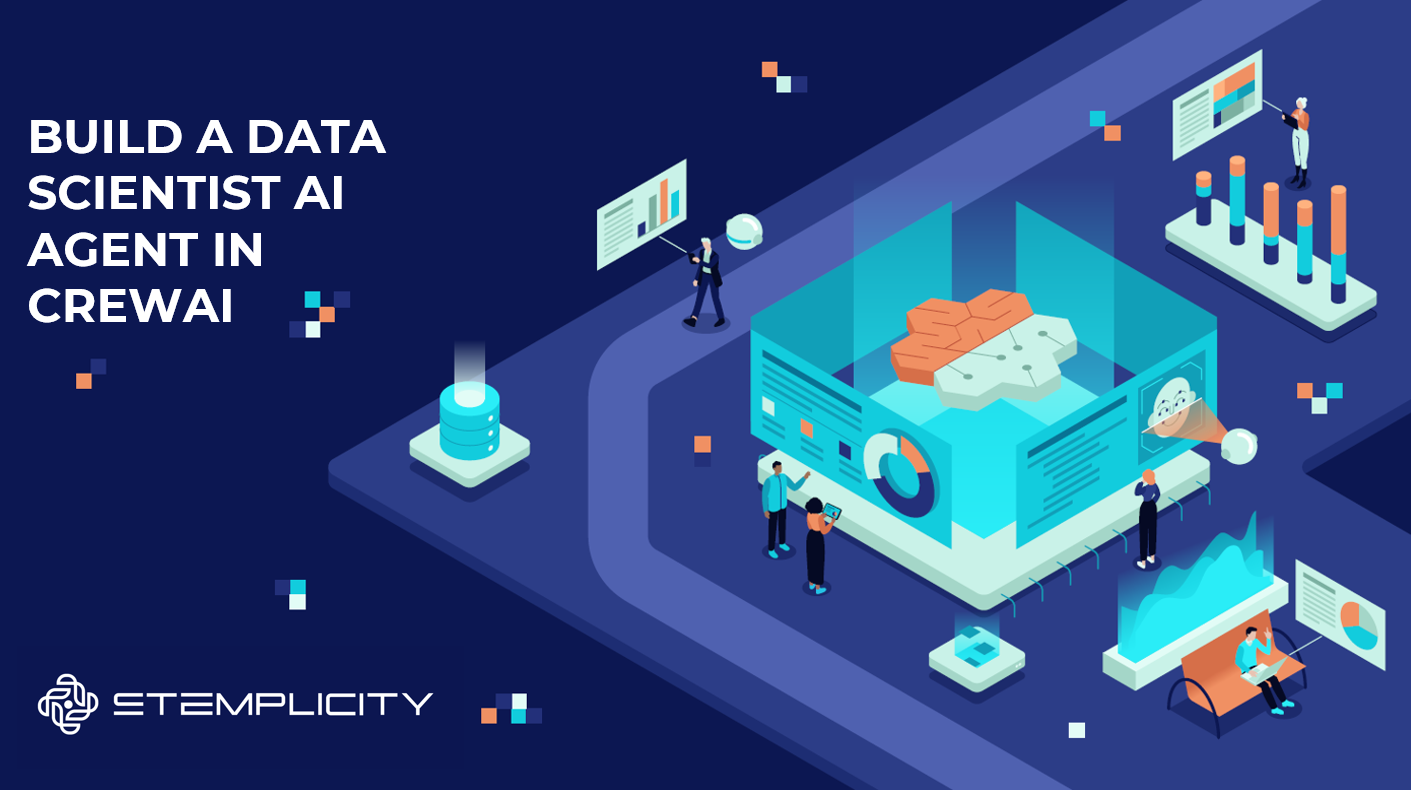

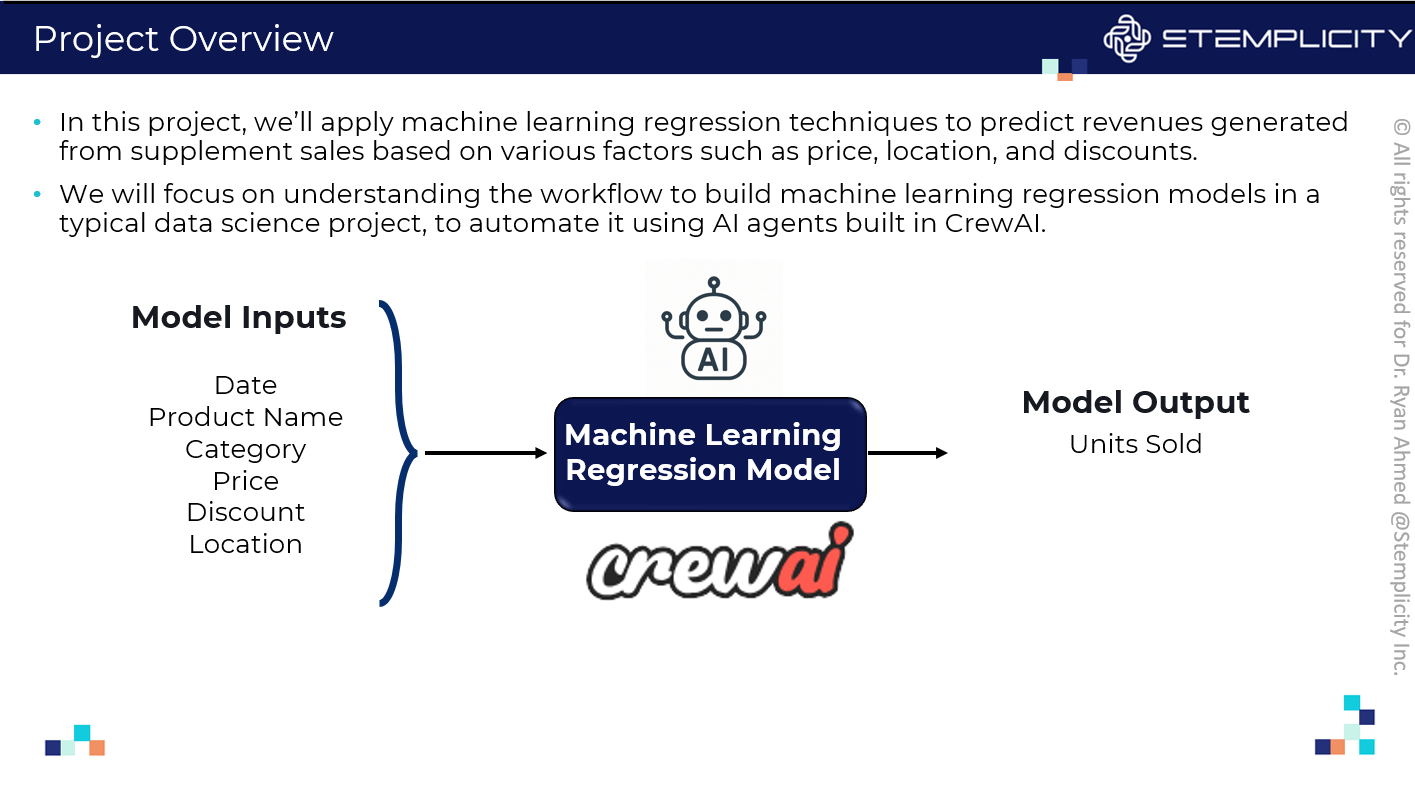

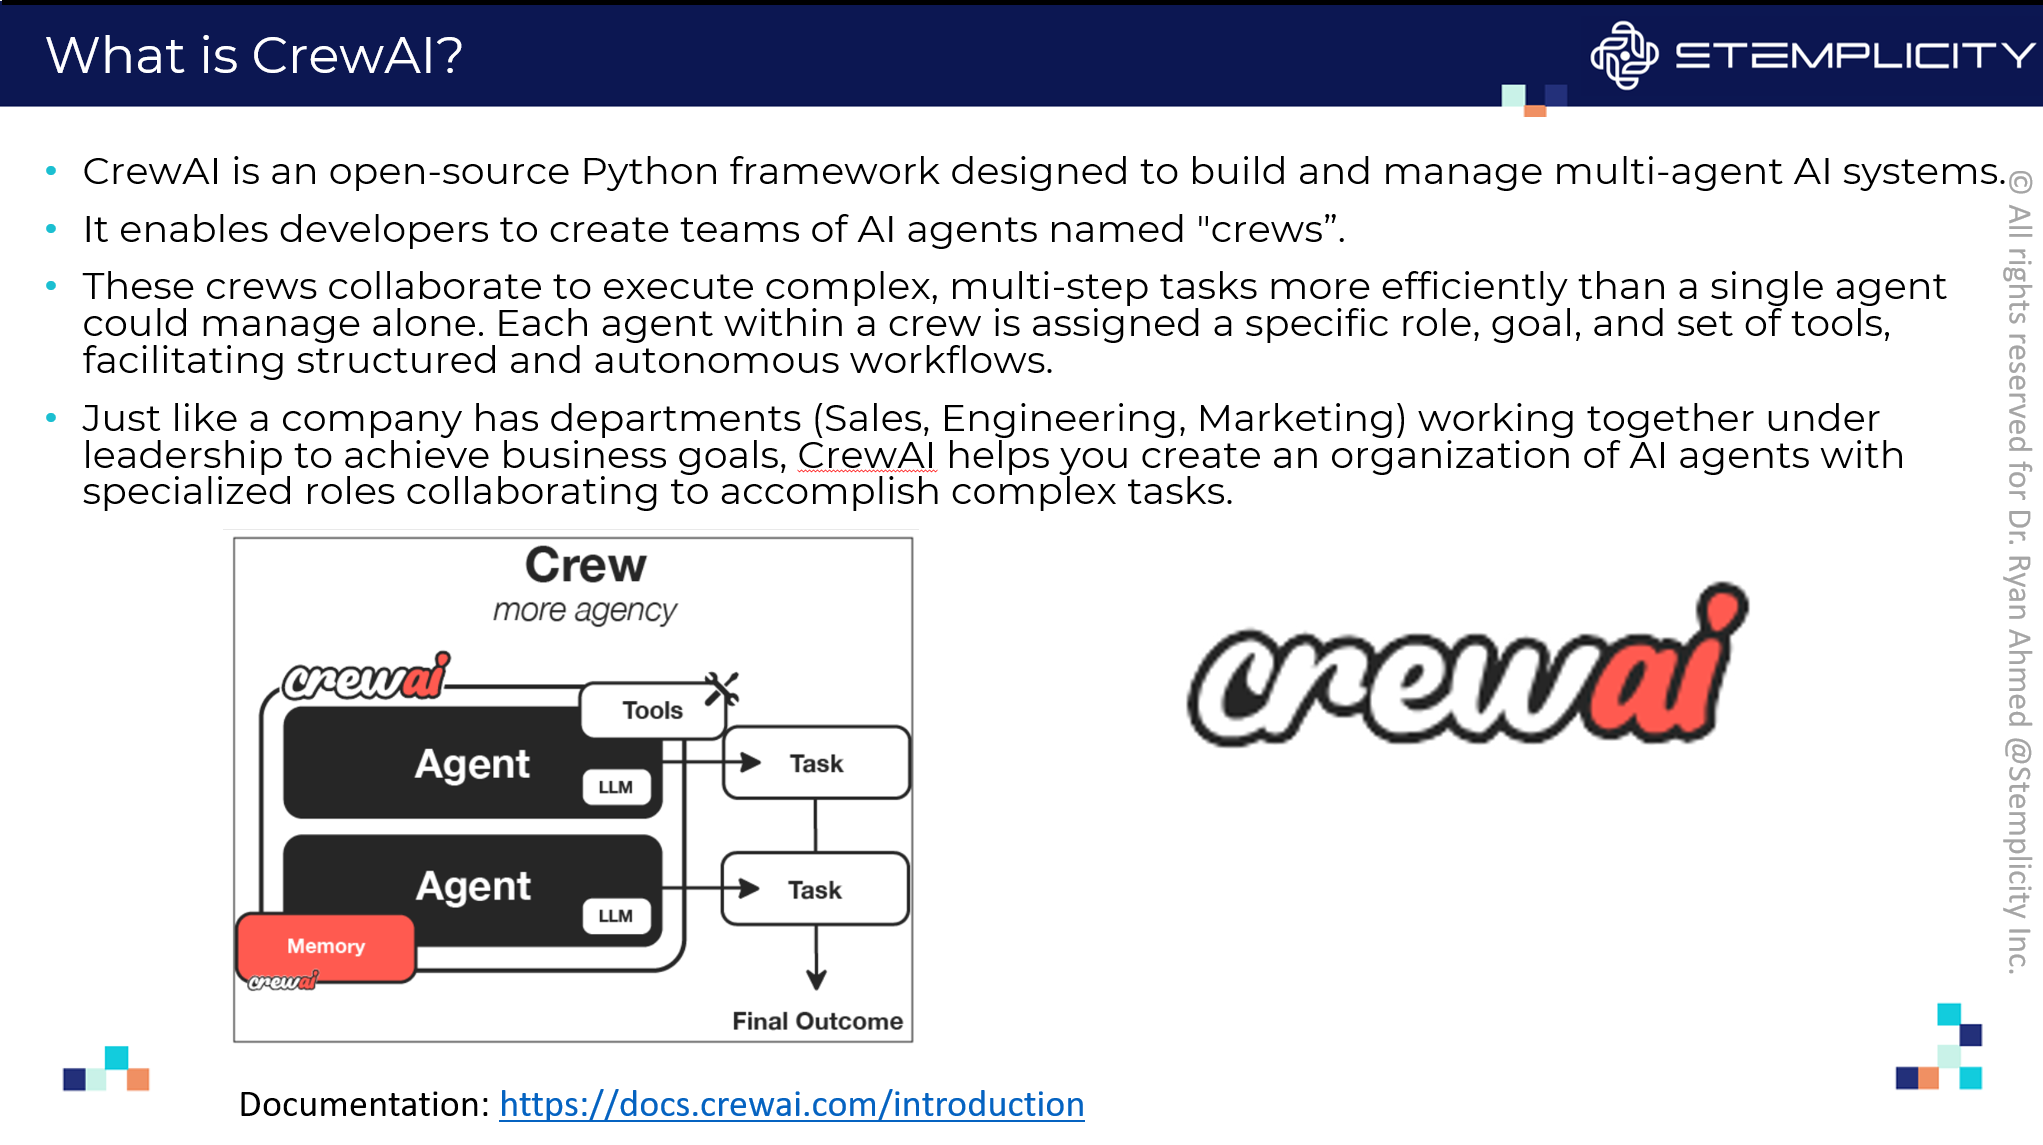

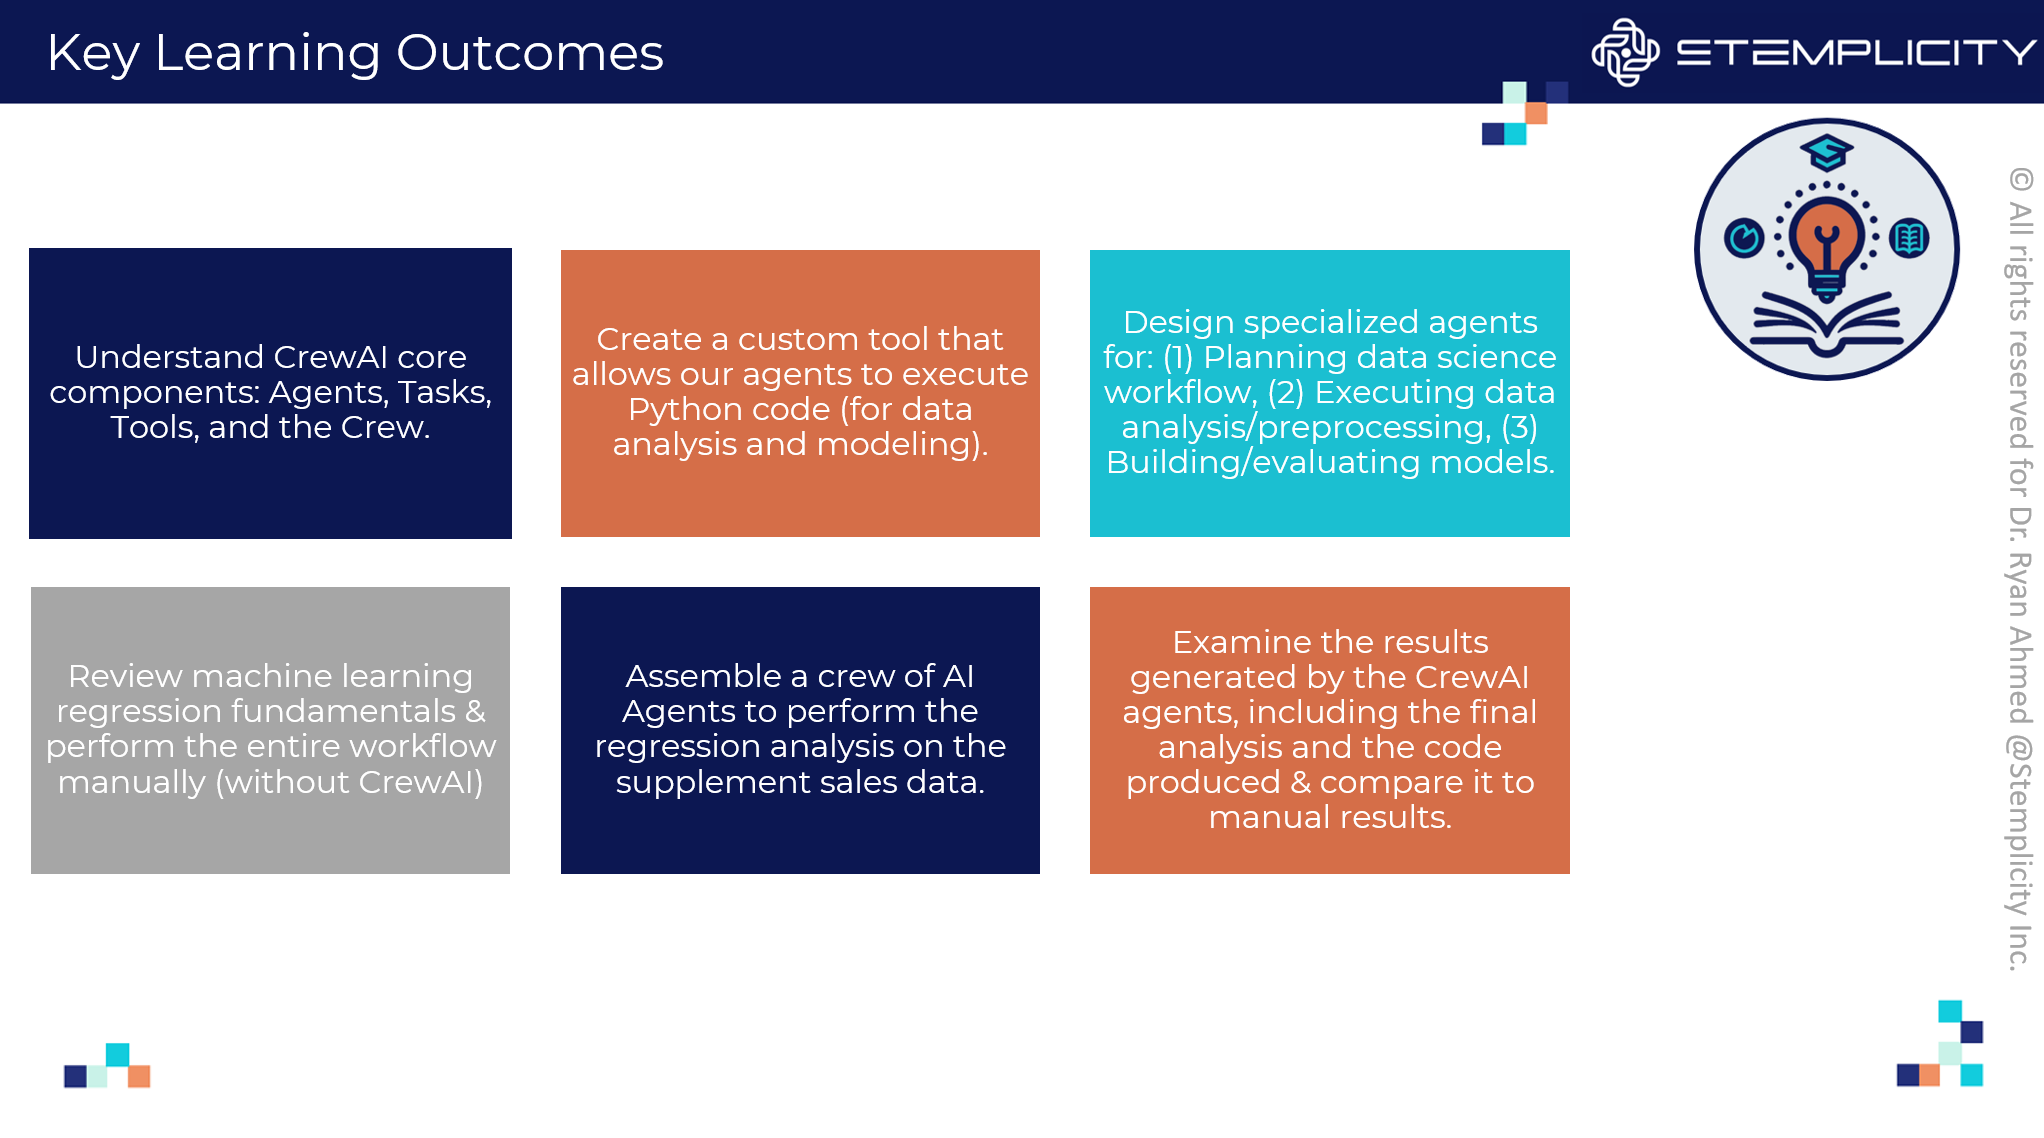

# TASK 2: BUILD, TRAIN & EVALUATE MACHINE LEARNING REGRESSION MODELS (MANUALLY)

- Please review the `Predictive Analytics Using Machine Learning.ipynb` Jupyter Notebook, which walks through the complete machine learning workflow, including exploratory data analysis, data visualization, data cleaning, handling missing values, model training (using Multiple Linear Regression, XGBoost, and Random Forest), and model evaluation.
- If you're already an experienced data scientist with a strong background, feel free to skip this notebook.

# TASK 3: UNDERSTAND CREWAI COMPONENTS

In our previous projects, we explored LLMs, Vision Models, and Gradio interfaces. We also manually built a regression model to predict supplement sales. Now, we'll combine these ideas by introducing **AI Agents** to automate the data science process!

**What are AI Agents?** Imagine a team of specialized AI assistants. Each agent has a specific role (like data analysis, planning, or coding) and can work together on a larger task. We'll use a framework called **CrewAI** to build and manage this team.

**Why CrewAI for Data Science?** Manually performing every step of a data science project (loading, cleaning, EDA, preprocessing, modeling, evaluation) can be time-consuming. CrewAI allows us to define agents that can:
*   **Plan:** Strategize the necessary steps based on the goal and data.
*   **Execute:** Perform tasks like data manipulation and model training, often by generating and running code.
*   **Collaborate:** Work sequentially or delegate tasks to achieve the final objective.

**Final Goal:** Build a CrewAI system that takes the supplement sales dataset (`Supplement_Sales_Weekly.csv`), automatically performs the key steps of regression analysis (similar to what we did manually), and provides the results and the generated code. We'll focus on using CrewAI with OpenAI models.

Let's build our AI data science team!


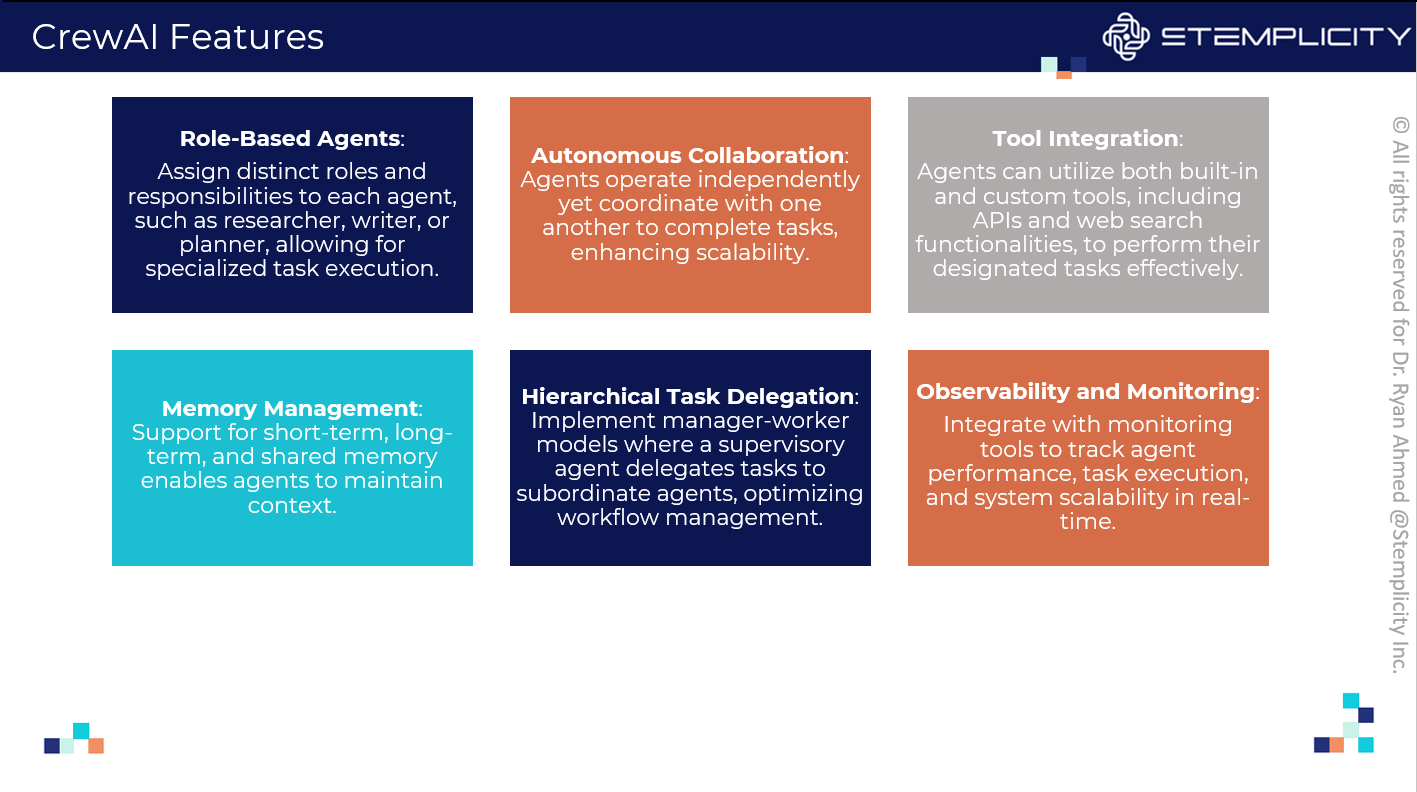

- **Documentation: https://docs.crewai.com/introduction**

CrewAI orchestrates LLM agents to work together. Let's break down the key building blocks:

1.  **Agents:** These are the individual AI workers. Each agent has:
    *   `role`: Defines their job title or specialization (e.g., 'Data Analyst', 'Python Coder').
    *   `goal`: Specifies their primary objective.
    *   `backstory`: Provides context about their skills and experience, helping the LLM adopt the right persona.
    *   `llm`: The language model that powers the agent's reasoning (we're using OpenAI's model).
    *   `tools` (Optional): A list of tools the agent can use to interact with the environment (e.g., search the web, run code, access files).
    *   `allow_delegation` (Optional): Boolean indicating if the agent can delegate tasks to other agents.
    *   `verbose`: Boolean to show the agent's thought process during execution.

2.  **Tools:** These are capabilities agents can use to perform actions beyond just generating text. Examples include:
    *   Searching the internet.
    *   Reading/writing files.
    *   Executing code (which we will create!).
    *   Interacting with APIs.
    Agents decide *when* and *how* to use the tools they have access to based on their assigned task.

3.  **Tasks:** These define the specific assignments for the agents. Each task has:
    *   `description`: A clear explanation of what needs to be done, including any necessary inputs or context.
    *   `expected_output`: A description of what a successful completion of the task looks like. This helps guide the agent.
    *   `agent`: The agent assigned to perform this task.
    *   `context` (Optional): A list of other tasks whose output should be provided as context to this task.

4.  **Crew:** This brings the agents and tasks together. It defines:
    *   `agents`: The list of agents participating in the crew.
    *   `tasks`: The list of tasks to be accomplished.
    *   `process`: The workflow strategy (e.g., `Process.sequential` where tasks are executed one after another in the order they are listed). Hierarchical processes are also possible for more complex delegation.

5.  **Process:** Defines how the tasks are executed.
    *   `sequential`: Tasks run one by one, the output of one feeding into the next if needed via context. Simple and predictable.
    *   `hierarchical`: A manager agent delegates tasks to subordinates. More complex but allows for dynamic task management. (We'll use sequential for this project).

By defining these components, we create an automated system where agents collaborate to achieve a complex goal, like performing our regression analysis.


# TASK 4: LOADING KEY LIBRARIES & THE `NotebookCodeExecutor` TOOL

Before we build our Crew, we need to install the necessary libraries and import them.

*   **crewai:** The core library for creating agents, tasks, and crews.
*   **openai:** Required if using OpenAI models as the brain for our agents.
*   **python-dotenv:** To manage API keys securely.
*   **pandas:** Although the agents will use pandas via code execution, we might need it here for initial setup or data loading verification.
*   **langchain_openai:** CrewAI uses LangChain components, so we need this for the OpenAI LLM integration.


In [1]:
!pip uninstall crewai -y
!pip install crewai --no-cache-dir

Found existing installation: crewai 0.118.0
Uninstalling crewai-0.118.0:
  Successfully uninstalled crewai-0.118.0


In [2]:
# Let's import crewAI
from crewai import Agent, Task, Crew, Process
from crewai.tools import BaseTool

In [ ]:
# Let's ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

# Install necessary libraries
# !pip install -q crewai python-dotenv langchain_openai pandas 

In [3]:
# Import necessary libraries
import os
import pandas as pd

from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import display, Markdown, Image

# Load environment variables (especially API keys)
load_dotenv()

# Configure API Key, which is essential for AI agents to use OpenAI models
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialize the LLM for the agents
llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", api_key = openai_api_key)



In [4]:
# Helper function to print markdowns
def print_markdown(text):
    """Displays text as Markdown in Jupyter."""
    display(Markdown(text))

The Notebook Executor tool will:
1.  Accept Python code as a string.
2.  Optionally accept a list of required Python libraries.
3.  Attempt to install the required libraries using `pip` within the current environment.
4.  Execute the provided Python code directly in the **notebook's global scope** using `exec()`. This allows interaction with existing variables like `shared_df`.
5.  Capture any output printed by the code.
6.  Return the captured output or any error messages (from installation or execution).

**🚨 SECURITY WARNING:** This tool executes arbitrary code directly in your environment using `exec(code, globals())`. Like `unsafe_mode=True`, this carries significant security risks. Only use it in trusted environments.


In [5]:
from notebookExecutor import NotebookCodeExecutor, NotebookCodeExecutorSchema

In [6]:
# First, let's load the data into a shared DataFrame that our tool can access
# This simulates the data being available in the execution environment
import pandas as pd
file_path = "Supplement_Sales_Weekly.csv"
shared_df = pd.read_csv(file_path)

In [7]:
# Let's test the Notebook Code executor tool 
# Let's define a basic function that adds two numbers
def add_numbers(a,b):
    return a + b

In [8]:
# Let's instantiate the custom tool
notebook_executor_tool = NotebookCodeExecutor(namespace=globals())
print("✅ Custom tool 'NotebookCodeExecutor' instantiated with notebook's global namespace.")

✅ Custom tool 'NotebookCodeExecutor' instantiated with notebook's global namespace.


In [9]:
# Test the tool
test_code = "print(add_numbers(1,2))"
print("\nTesting tool:\n")
print(notebook_executor_tool.run(code = test_code))



Testing tool:

Using Tool: Notebook Code Executor
--- Executing Code ---
Code executed successfully. Output:
```output
3

```



**PRACTICE OPPORTUNITY:**
- **Create new function that takes in two strings and combines them into a single string using "_" in between them, and try to use the tool to execute this function.**

# TASK 5: DEFINING THE AGENTS WITH CODE GENERATION FOCUS

We define the agents, emphasizing their ability to *write* Python code for their tasks and then use the `notebook_executor_tool` to run it.


In [12]:
# Define the Data Science Planner Agent (no tool needed)
planner_agent = Agent(role = "Lead Data Scientist and Planner",
                      goal = ("Analyze the objective (predict 'Units Sold') assuming data is in a global pandas DataFrame 'shared_df'. "
                              "Create a step-by-step plan for regression analysis. Instruct subsequent agents on the GOALS for each step."
                              "(e.g., inspect data, preprocess, model, evaluate) and tell them to use the 'Notebook Code Executor' tool "
                              "to WRITE and EXECUTE the necessary Python code."),
                    backstory = ("Experienced data scientist planning ML projects. Knows data is in 'shared_df' and agents will write and execute code using a tool."),
                    llm = llm,
                    allow_delegation = False,
                    verbose = True)

In [13]:
# Define the Data Analysis and Preprocessing Agent (needs access to notebook_executer_tool to generate code)
analyst_preprocessor_agent = Agent(role = "Data Analysis and Preprocessing Expert",
                                   goal = (
        "Follow the plan for data analysis and preprocessing. **Write the necessary Python code** using pandas and scikit-learn "
        "to operate on the global pandas DataFrame 'shared_df'. Your code must perform inspection (shape, info, nulls, describe), "
        "handle date/identifiers (convert 'Date', sort, drop 'Date'/'Product Name'), encode categoricals (OneHotEncode 'Platform' modifying 'shared_df'), "
        "and finally **create the global variables X_train, X_test, y_train, y_test** from 'shared_df' using an 80/20 split (shuffle=False). "
        "Use the 'Notebook Code Executor' tool to execute the code you write. Ensure your generated code includes print statements for key results."),
    
                                   backstory = (
        "Meticulous analyst skilled in writing pandas/sklearn code. Uses the 'Notebook Code Executor' tool to run the generated code. "
        "Knows data is in global 'shared_df' and must create global train/test variables."),
                                   llm = llm,
                                   tools = [notebook_executor_tool],  # Assign the custom tool explicitly
                                   allow_delegation = False,
                                   verbose = True)


In [14]:
# Define the Modeling and Evaluation Agent (needs access to notebook_executer_tool to generate code)
modeler_evaluator_agent = Agent(role = "Machine Learning Modeler and Evaluator",
                                goal = (
        "Follow the plan for modeling and evaluation. **Write the necessary Python code** using scikit-learn. "
        "Assume global variables X_train, X_test, y_train, y_test exist. Your code must train a RandomForestRegressor(random_state=42), "
        "make predictions on X_test, calculate and print evaluation metrics (MAE, MSE, RMSE, R²), and print the top 10 feature importances. "
        "Use the 'Notebook Code Executor' tool to execute the code you write. "
        "Finally, include the exact Python code you generated and executed in your final response, formatted in a markdown block."
    ),
                                backstory = (
        "ML engineer specialized in regression. Writes scikit-learn code and uses the 'Notebook Code Executor' tool to run it. "
        "Expects global train/test split variables (X_train etc.) to be available."
    ),
    llm = llm,
    tools = [notebook_executor_tool],  # Assign the custom tool explicitly
    allow_delegation = False,
    verbose = True)


In [15]:
print("✅ CrewAI Agents defined, focusing on code generation.")
print(f"- {planner_agent.role}")
print(f"- {analyst_preprocessor_agent.role} (Tool: {analyst_preprocessor_agent.tools[0].name})")
print(f"- {modeler_evaluator_agent.role} (Tool: {modeler_evaluator_agent.tools[0].name})")

✅ CrewAI Agents defined, focusing on code generation.
- Lead Data Scientist and Planner
- Data Analysis and Preprocessing Expert (Tool: Notebook Code Executor)
- Machine Learning Modeler and Evaluator (Tool: Notebook Code Executor)


**PRACTICE OPPORTUNITY:**
- **Modify the `analyst_preprocessor_agent` to ensure that the data is shuffled when performing the train/test split.**
- **Take a moment to carefully consider all aspects of the agent definition that may need to be updated to support this change.**

# TASK 6: DEFINING KEY TASKS & RESPONSIBLE AGENT


Tasks now provide high-level instructions, guiding the agents on the objectives for each step and reminding them to generate the necessary Python code and execute it using the `Notebook Code Executor` tool, ensuring interaction with the global state (`shared_df`, `X_train`, etc.).


In [16]:
# Define the Planning Task (Stays largely the same, instructs agents on GOALS)
planning_task = Task(
    description = (
        "1. Goal: Create a plan for regression predicting 'Units Sold'.\n"
        "2. Data Context: Global pandas DataFrame 'shared_df' is available.\n"
        "3. Plan Steps: Outline sequence, instructing agents on their GOALS for each step and to use the 'Notebook Code Executor' tool to WRITE and RUN Python code:\n"
        "    a. Goal: Inspect global 'shared_df' (shape, info, nulls, describe).\n"
        "    b. Goal: Preprocess global 'shared_df' (handle Date [to_datetime, sort, drop], drop identifiers ['Product Name'], OneHotEncode 'Platform' [update 'shared_df'], create global X/y vars, create global train/test split vars X_train/test, y_train/test [80/20, shuffle=False]).\n"
        "    c. Goal: Train RandomForestRegressor using global X_train, y_train (use random_state=42).\n"
        "    d. Goal: Evaluate model on global X_test (predict, calc & print MAE, MSE, RMSE, R2).\n"
        "    e. Goal: Extract & print top 10 feature importances from the trained model.\n"
        "5. Output: Numbered plan focusing on the objectives for each data science step."
    ),
    expected_output = (
        "Numbered plan outlining the data science goals for subsequent agents, reminding them to generate code and use the 'Notebook Code Executor' tool, interacting with global variables like 'shared_df' and 'X_train'."
    ),
    agent = planner_agent)


In [17]:
# Define the Data Analysis and Preprocessing Task (High-level instructions)
data_analysis_preprocessing_task = Task(
    description = (
        "Follow the analysis/preprocessing plan. Your goal is to inspect and prepare the global 'shared_df' DataFrame and create global training/testing variables. "
        "You MUST **generate Python code** to achieve this and then execute it using the 'Notebook Code Executor' tool. "
        "Specifically, your generated code needs to:\n"
        "1. Inspect the 'shared_df' DataFrame (print shape, info(), isnull().sum(), describe()).\n"
        "2. Convert 'Date' column in 'shared_df' to datetime objects, sort 'shared_df' by 'Date', then drop the 'Date' and 'Product Name' columns from 'shared_df'.\n"
        "3. One-Hot Encode the 'Platform' column in 'shared_df' (use pd.get_dummies, drop_first=True). **Crucially, ensure 'shared_df' DataFrame variable is updated with the result of the encoding.**\n"
        "4. Create a global variable 'y' containing the 'Units Sold' column from 'shared_df'.\n"
        "5. Create a global variable 'X' containing the remaining columns from the updated 'shared_df' (after dropping 'Units Sold').\n"
        "6. Split 'X' and 'y' into global variables: 'X_train', 'X_test', 'y_train', 'y_test' using an 80/20 split with `shuffle=False`. Ensure these four variables are created in the global scope.\n"
        "Make sure your generated code includes necessary imports (like pandas, train_test_split) and print statements for verification (e.g., printing shapes of created variables like X_train.shape)."
        # "Remember to pass the required libraries (e.g., ['pandas', 'scikit-learn']) to the tool if your code uses them, although they should be pre-imported in this notebook." # Optional hint, often the agent figures out imports
    ),
    expected_output = (
        "Output from the 'Notebook Code Executor' tool showing the successful execution of agent-generated code. This includes printouts confirming:\n"
        "- Initial data inspection results for 'shared_df'.\n"
        "- Confirmation of DataFrame modifications (e.g., shape after encoding).\n"
        "- Confirmation of the creation and shapes of global variables X, y, X_train, X_test, y_train, y_test."
    ),
    agent = analyst_preprocessor_agent,
    tools = [notebook_executor_tool],  # Explicitly list tool
)


In [18]:
# Define the Modeling and Evaluation Task (High-level instructions)
modeling_evaluation_task = Task(
    description = (
        "Follow the modeling/evaluation plan. Your goal is to train a model, evaluate it, and report results. "
        "You MUST **generate Python code** assuming global variables X_train, X_test, y_train, y_test exist, and execute it using the 'Notebook Code Executor' tool. "
        "Specifically, your generated code needs to:\n"
        "1. Train a `RandomForestRegressor` model (use `random_state=42`) using the global `X_train` and `y_train` variables. Store the trained model in a global variable named `trained_model`.\n"
        "2. Make predictions on the global `X_test` variable.\n"
        "3. Calculate and print the MAE, MSE, RMSE, and R-squared metrics by comparing predictions against the global `y_test` variable.\n"
        "4. Calculate and print the top 10 feature importances from the trained model (using `X_train.columns` for feature names).\n"
        "Make sure your generated code includes necessary imports (like RandomForestRegressor, metrics functions from sklearn.metrics, numpy, pandas) and print statements for all results.\n"
        "Finally, include the exact Python code you generated and executed within a markdown code block (```python...```) in your final response."
        # "Remember to pass required libraries like ['scikit-learn', 'pandas', 'numpy'] to the tool if needed." # Optional hint
    ),
    expected_output = (
        "Output from the 'Notebook Code Executor' tool showing the successful execution of agent-generated code, including:\n"
        "- Printed regression metrics (MAE, MSE, RMSE, R²).\n"
        "- Printed top 10 feature importances.\n"
        "The final response MUST also contain a markdown code block (```python...```) showing the exact Python code that was generated and executed for these steps."
    ),
    agent = modeler_evaluator_agent,
    tools = [notebook_executor_tool],  # Explicitly list tool
)

print("✅ CrewAI Tasks defined with high-level instructions for code generation.")

✅ CrewAI Tasks defined with high-level instructions for code generation.


# TASK 7: CREATING AND RUNNING THE CREW

Let's assemble the crew. The agents will now attempt to generate and execute the code needed for their tasks using the `NotebookCodeExecutor` tool. This may take longer and require more careful observation of the verbose output to ensure correctness.

In [19]:
# Let's Create the Crew
regression_crew = Crew(
    agents = [planner_agent, analyst_preprocessor_agent, modeler_evaluator_agent],
    tasks = [planning_task, data_analysis_preprocessing_task, modeling_evaluation_task],
    process = Process.sequential,
    verbose = 1,  # Use detailed output to see agent thoughts and tool usage
    output_log_file = True)

In [20]:
# Kick off the crew execution!
print("Starting the Crew execution (Agents will generate code)...")

# Ensure the initial DataFrame exists before starting
crew_result = regression_crew.kickoff()

Starting the Crew execution (Agents will generate code)...


╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 5482b723-0ea9-405c-93ac-c83813e4373d                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
└── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
       Status: Executing Task...

🚀 Crew: crew
└── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
       Status: Executing Task...
    └── 🤖 Agent: Lead Data Scientist and Planner
            Status: In Progress

# Agent: Lead Data Scientist and Planner
## Task: 1. Goal: Create a plan for regression predicting 'Units Sold'.
2. Data Context: Global pandas DataFrame 'shared_df' is available.
3. Plan Steps: Outline sequence, instructing agents on their GOALS for each step and to use the 'Notebook Code Executor' tool to WRITE and RUN Python code:
    a. Goal: Inspect global 'shared_df' (shape, info, nulls, describe).
    b. Goal: Preprocess global 'shared_df' (handle Date [to_datetime, sort, drop], drop identifiers ['Product Name'], OneHotEncode 'Platform' [update 'shared_df'], create global X/y vars, create global train/test split vars X_train/test, y_train/test [80/20, shuffle=False]).
    c. Goal: Train RandomForestRegressor using global X_train, y_train (use random_state=42).
    d. Goal: Evaluate model on global X_test (predict, calc & print MAE, MSE, RMSE, R2).
    e. Goal: Extract & print top 10 feature importances from the trained model.
5. Output: Numbered plan focusing on the objectives f

🤖 Agent: Lead Data Scientist and Planner
    Status: In Progress
└── 🧠 Thinking...

🤖 Agent: Lead Data Scientist and Planner
    Status: In Progress



# Agent: Lead Data Scientist and Planner
## Final Answer: 
1. Goal: Inspect the global DataFrame 'shared_df' to understand its structure and content. Agents should use the 'Notebook Code Executor' tool to WRITE and EXECUTE Python code that outputs the shape, info summary, count of null values per column, and descriptive statistics of the dataset.

2. Goal: Preprocess the global 'shared_df' for regression modeling. Agents should:
   - Convert the 'Date' column to datetime format, sort the DataFrame by 'Date', then drop the 'Date' column.
   - Drop identifier columns such as 'Product Name' to avoid data leakage.
   - One-Hot Encode the categorical 'Platform' column, updating 'shared_df' accordingly.
   - Define global feature matrix 'X' and target vector 'y' where 'y' is 'Units Sold'.
   - Perform a train/test split on X and y with 80% training and 20% testing data, ensuring shuffle=False to respect temporal ordering, and create global variables X_train, X_test, y_train, y_test.
   Age

🚀 Crew: crew
└── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
       Status: Executing Task...
    └── 🤖 Agent: Lead Data Scientist and Planner
            Status: ✅ Completed

🚀 Crew: crew
└── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
       Assigned to: Lead Data Scientist and Planner
       Status: ✅ Completed
    └── 🤖 Agent: Lead Data Scientist and Planner
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: f020dc21-f938-483a-8993-66d96ac254bf                                                                     │
│  Agent: Lead Data Scientist and Planner                                                                         │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
└── 📋 Task: 96f0a77d-e07d-4ee5-80e7-186e5ca7629e
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
└── 📋 Task: 96f0a77d-e07d-4ee5-80e7-186e5ca7629e
       Status: Executing Task...
    └── 🤖 Agent: Data Analysis and Preprocessing Expert
            Status: In Progress

# Agent: Data Analysis and Preprocessing Expert
## Task: Follow the analysis/preprocessing plan. Your goal is to inspect and prepare the global 'shared_df' DataFrame and create global training/testing variables. You MUST **generate Python code** to achieve this and then execute it using the 'Notebook Code Executor' tool. Specifically, your generated code needs to:
1. Inspect the 'shared_df' DataFrame (print shape, info(), isnull().sum(), describe()).
2. Convert 'Date' column in 'shared_df' to datetime objects, sort 'shared_df' by 'Date', then drop the 'Date' and 'Product Name' columns from 'shared_df'.
3. One-Hot Encode the 'Platform' column in 'shared_df' (use pd.get_dummies, drop_first=True). **Crucially, ensure 'shared_df' DataFrame variable is updated with the result of the encoding.**
4. Create a global variable 'y' containing the 'Units Sold' column from 'shared_df'.
5. Create a global variable 'X' containing the remaining columns from the updated 'shared_df' (after dropping 'Uni

🤖 Agent: Data Analysis and Preprocessing Expert
    Status: In Progress



# Agent: Data Analysis and Preprocessing Expert
## Thought: Thought: I need to write code to inspect the shared_df DataFrame by printing its shape, info, null values count, and descriptive statistics. Then convert the 'Date' column to datetime, sort by date, drop 'Date' and 'Product Name' columns, perform one-hot encoding on the 'Platform' column updating shared_df, create target y and feature matrix X, and then split into train/test sets with shuffle=False. I will include print statements for all key stages.
## Using tool: Notebook Code Executor
## Tool Input: 
"{\"code\": \"import pandas as pd\\nfrom sklearn.model_selection import train_test_split\\n\\n# Step 1: Inspect the shared_df DataFrame\\nprint('Initial shape of shared_df:', shared_df.shape)\\nprint('\\\\nInfo of shared_df:')\\nshared_df.info()\\nprint('\\\\nCount of null values per column:')\\nprint(shared_df.isnull().sum())\\nprint('\\\\nDescriptive statistics of shared_df:')\\nprint(shared_df.describe(include='all'))\\n\\

🤖 Agent: Data Analysis and Preprocessing Expert
    Status: In Progress
└── 🧠 Thinking...

🤖 Agent: Data Analysis and Preprocessing Expert
    Status: In Progress



# Agent: Data Analysis and Preprocessing Expert
## Final Answer: 
Initial shape of shared_df: (4384, 8)

Info of shared_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4384 non-null   object 
 1   Product Name  4384 non-null   object 
 2   Category      4384 non-null   object 
 3   Units Sold    4384 non-null   int64  
 4   Price         4376 non-null   float64
 5   Discount      4379 non-null   float64
 6   Location      4384 non-null   object 
 7   Platform      4384 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 274.1+ KB

Count of null values per column:
Date            0
Product Name    0
Category        0
Units Sold      0
Price           8
Discount        5
Location        0
Platform        0
dtype: int64

Descriptive statistics of shared_df:
              Date  Product Name Category   U

🚀 Crew: crew
├── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
└── 📋 Task: 96f0a77d-e07d-4ee5-80e7-186e5ca7629e
       Status: Executing Task...
    └── 🤖 Agent: Data Analysis and Preprocessing Expert
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
└── 📋 Task: 96f0a77d-e07d-4ee5-80e7-186e5ca7629e
       Assigned to: Data Analysis and Preprocessing Expert
       Status: ✅ Completed
    └── 🤖 Agent: Data Analysis and Preprocessing Expert
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 96f0a77d-e07d-4ee5-80e7-186e5ca7629e                                                                     │
│  Agent: Data Analysis and Preprocessing Expert                                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
├── 📋 Task: 96f0a77d-e07d-4ee5-80e7-186e5ca7629e
│      Assigned to: Data Analysis and Preprocessing Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Analysis and Preprocessing Expert
│           Status: ✅ Completed
└── 📋 Task: f8a64ffa-4191-44a4-9c67-40980e5dbd8b
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
├── 📋 Task: 96f0a77d-e07d-4ee5-80e7-186e5ca7629e
│      Assigned to: Data Analysis and Preprocessing Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Analysis and Preprocessing Expert
│           Status: ✅ Completed
└── 📋 Task: f8a64ffa-4191-44a4-9c67-40980e5dbd8b
       Status: Executing Task...
    └── 🤖 Agent: Machine Learning Modeler and Evaluator
            Status: In Progress

# Agent: Machine Learning Modeler and Evaluator
## Task: Follow the modeling/evaluation plan. Your goal is to train a model, evaluate it, and report results. You MUST **generate Python code** assuming global variables X_train, X_test, y_train, y_test exist, and execute it using the 'Notebook Code Executor' tool. Specifically, your generated code needs to:
1. Train a `RandomForestRegressor` model (use `random_state=42`) using the global `X_train` and `y_train` variables. Store the trained model in a global variable named `trained_model`.
2. Make predictions on the global `X_test` variable.
3. Calculate and print the MAE, MSE, RMSE, and R-squared metrics by comparing predictions against the global `y_test` variable.
4. Calculate and print the top 10 feature importances from the trained model (using `X_train.columns` for feature names).
Make sure your generated code includes necessary imports (like RandomForestRegressor, metrics functions from sklearn.metrics, numpy, pandas) and print sta

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress



# Agent: Machine Learning Modeler and Evaluator
## Thought: Action: Notebook Code Executor
## Using tool: Notebook Code Executor
## Tool Input: 
"{\"code\": \"from sklearn.ensemble import RandomForestRegressor\\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\\nimport numpy as np\\nimport pandas as pd\\n\\n# Train the RandomForestRegressor model\\ntrained_model = RandomForestRegressor(random_state=42)\\ntrained_model.fit(X_train, y_train)\\n\\n# Make predictions on the test set\\npredictions = trained_model.predict(X_test)\\n\\n# Calculate evaluation metrics\\nmae = mean_absolute_error(y_test, predictions)\\nmse = mean_squared_error(y_test, predictions)\\nrmse = np.sqrt(mse)\\nr2 = r2_score(y_test, predictions)\\n\\n# Print evaluation metrics\\nprint(f\\\"Mean Absolute Error (MAE): {mae:.4f}\\\")\\nprint(f\\\"Mean Squared Error (MSE): {mse:.4f}\\\")\\nprint(f\\\"Root Mean Squared Error (RMSE): {rmse:.4f}\\\")\\nprint(f\\\"R-squared (R2): {r2:.4f}\\\")\\n

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress
└── 🧠 Thinking...

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress



# Agent: Machine Learning Modeler and Evaluator
## Thought: Thought: The error "could not convert string to float: 'Protein'" indicates that there are still categorical string features in X_train that were not properly encoded to numeric values. I need to check if any categorical columns besides 'Platform' remain unencoded in X_train. I recall from the preprocessing that 'Category' and 'Location' columns are still categorical strings. I must encode these categorical columns (e.g., via one-hot encoding or label encoding) before fitting the RandomForestRegressor model. I will write and execute code to encode these columns in X_train and X_test, then retrain and evaluate the model.
## Using tool: Notebook Code Executor
## Tool Input: 
"{\"code\": \"# Check for categorical columns in X_train\\ncategorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()\\nprint(f\\\"Categorical columns in X_train: {categorical_cols}\\\")\\n\\n# One-hot encode categorical columns ('Catego

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress
└── 🧠 Thinking...

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress



# Agent: Machine Learning Modeler and Evaluator
## Final Answer: 
```
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Check for categorical columns in X_train
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns in X_train: {categorical_cols}")

# One-hot encode categorical columns ('Category' and 'Location') in both train and test
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align train and test columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Train the RandomForestRegressor model on encoded data
trained_model = RandomForestRegressor(random_state=42)
trained_model.fit(X_train_encoded, y_train)

# Make predictions
predi

🚀 Crew: crew
├── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
├── 📋 Task: 96f0a77d-e07d-4ee5-80e7-186e5ca7629e
│      Assigned to: Data Analysis and Preprocessing Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Analysis and Preprocessing Expert
│           Status: ✅ Completed
└── 📋 Task: f8a64ffa-4191-44a4-9c67-40980e5dbd8b
       Status: Executing Task...
    └── 🤖 Agent: Machine Learning Modeler and Evaluator
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: f020dc21-f938-483a-8993-66d96ac254bf
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
├── 📋 Task: 96f0a77d-e07d-4ee5-80e7-186e5ca7629e
│      Assigned to: Data Analysis and Preprocessing Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Analysis and Preprocessing Expert
│           Status: ✅ Completed
└── 📋 Task: f8a64ffa-4191-44a4-9c67-40980e5dbd8b
       Assigned to: Machine Learning Modeler and Evaluator
       Status: ✅ Completed
    └── 🤖 Agent: Machine Learning Modeler and Evaluator
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: f8a64ffa-4191-44a4-9c67-40980e5dbd8b                                                                     │
│  Agent: Machine Learning Modeler and Evaluator                                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 5482b723-0ea9-405c-93ac-c83813e4373d                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [21]:
print("\n\n🏁 Crew execution finished.")
print("\nCrew Final Result (Output of last task):")
print("========================================")

print_markdown(crew_result.raw)



🏁 Crew execution finished.

Crew Final Result (Output of last task):


```
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Check for categorical columns in X_train
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns in X_train: {categorical_cols}")

# One-hot encode categorical columns ('Category' and 'Location') in both train and test
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align train and test columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Train the RandomForestRegressor model on encoded data
trained_model = RandomForestRegressor(random_state=42)
trained_model.fit(X_train_encoded, y_train)

# Make predictions
predictions = trained_model.predict(X_test_encoded)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Feature importances
feature_importances = pd.Series(trained_model.feature_importances_, index=X_train_encoded.columns)
top_10_features = feature_importances.sort_values(ascending=False).head(10)
print("\nTop 10 Feature Importances:")
print(top_10_features)
```

**PRACTICE OPPORTUNITY:** 
- **Add one more to our comparison: the Decision Tree Regressor.**
- **Evaluate its performance and compare the results with the Random Forest Regressor and our previous models.**

# PRACTICE OPPORTUNITIES SOLUTIONS

**PRACTICE OPPORTUNITY SOLUTION:**
- **Create a new function that takes in two strings and combines them into a single string using "_" in between them, and try to use the tool to execute this function.**

In [10]:
def combine_string(str1, str2):
    return str1 + "_" + str2

In [11]:
test_code = "print(combine_string('llm','engineering'))"
print("\nTesting tool:\n")
print(notebook_executor_tool.run(code = test_code))



Testing tool:

Using Tool: Notebook Code Executor
--- Executing Code ---
Code executed successfully. Output:
```output
llm_engineering

```



**PRACTICE OPPORTUNITY SOLUTION:**
- **Modify the `analyst_preprocessor_agent` to ensure that the data is shuffled when performing the train/test split.**
- **Take a moment to carefully consider all aspects of the agent definition that may need to be updated to support this change.**

In [ ]:
# Define the Data Analysis and Preprocessing Agent (needs tool, generates code)
analyst_preprocessor_agent = Agent(role = "Data Analysis and Preprocessing Expert",
                                   goal = (
        "Follow the plan for data analysis and preprocessing. **Write the necessary Python code** using pandas and scikit-learn "
        "to operate on the global pandas DataFrame 'shared_df'. Your code must perform inspection (shape, info, nulls, describe), impute missing values, "
        "handle date/identifiers (convert 'Date', sort, drop 'Date'/'Product Name'), encode categoricals (OneHotEncode 'Platform' modifying 'shared_df'), "
        "and finally **create the global variables X_train, X_test, y_train, y_test** from 'shared_df' using an 80/20 split (shuffle=True). "
        "Use the 'Notebook Code Executor' tool to execute the code you write. Ensure your generated code includes print statements for key results."),
    
                                   backstory = (
        "Meticulous analyst skilled in writing pandas/sklearn code. Uses the 'Notebook Code Executor' tool to run the generated code. "
        "Knows data is in global 'shared_df' and must create global train/test variables."),
                                   llm = llm,
                                   tools = [notebook_executor_tool],  # Assign the custom tool explicitly
                                   allow_delegation = False,
                                   verbose = True)


**PRACTICE OPPORTUNITY SOLUTION:** 
- **Add one more to our comparison: the Decision Tree Regressor.**
- **Evaluate its performance and compare the results with the Random Forest Regressor and our previous models.**

In [25]:
shared_df = pd.read_csv(file_path)

planner_agent = Agent(
    role = "Lead Data Scientist and Planner",
    goal = (
        "Analyze the objective (predict 'Units Sold') assuming data is in a global pandas DataFrame 'shared_df'. "
        "Create a step-by-step plan for regression analysis. Instruct subsequent agents on the GOALS for each step "
        "(e.g., inspect data, preprocess, model, evaluate) and tell them to use the 'Notebook Code Executor' tool "
        "to WRITE and EXECUTE the necessary Python code."
    ),
    backstory = (
        "Experienced data scientist planning ML projects. Knows data is in 'shared_df' and agents will write and execute code using a tool."
    ),
    llm = llm,
    allow_delegation = False,
    verbose = True,
)

# Define the Data Analysis and Preprocessing Agent (needs tool, generates code)
analyst_preprocessor_agent = Agent(
    role = "Data Analysis and Preprocessing Expert",
    goal=(
        "Follow the plan for data analysis and preprocessing. **Write the necessary Python code** using pandas and scikit-learn "
        "to operate on the global pandas DataFrame 'shared_df'. Your code must perform inspection (shape, info, nulls, describe), "
        "handle date/identifiers (convert 'Date', sort, drop 'Date'/'Product Name'), encode categoricals (OneHotEncode 'Platform' modifying 'shared_df'), "
        "and finally **create the global variables X_train, X_test, y_train, y_test** from 'shared_df' using an 80/20 split (shuffle=False). "
        "Use the 'Notebook Code Executor' tool to execute the code you write. Ensure your generated code includes print statements for key results."
    ),
    backstory = (
        "Meticulous analyst skilled in writing pandas/sklearn code. Uses the 'Notebook Code Executor' tool to run the generated code. "
        "Knows data is in global 'shared_df' and must create global train/test variables."
    ),
    llm = llm,
    tools = [notebook_executor_tool],  # Assign the custom tool explicitly
    allow_delegation = False,
    verbose = True,
)

# Define the Modeling and Evaluation Agent (needs tool, generates code)
modeler_evaluator_agent = Agent(
    role = "Machine Learning Modeler and Evaluator",
    goal = (
        "Follow the plan for modeling and evaluation. **Write the necessary Python code** using scikit-learn. "
        "Assume global variables X_train, X_test, y_train, y_test exist. Your code must train both a Decision Tree model and a Random Forest model, "
        "make predictions on X_test with both models, calculate and print evaluation metrics (MAE, MSE, RMSE, R²) for both models, compare their performance, "
        "and print the top 10 feature importances for each model. "
        "Use the 'Notebook Code Executor' tool to execute the code you write. "
        "Finally, include the exact Python code you generated and executed in your final response, formatted in a markdown block."
    ),
    backstory = (
        "ML engineer specialized in regression. Writes code and uses the 'Notebook Code Executor' tool to run it. "
        "Expects global train/test split variables (X_train etc.) to be available."
    ),
    llm = llm,
    tools = [notebook_executor_tool],  # Assign the custom tool explicitly
    allow_delegation = False,
    verbose = True,
)

In [26]:

planning_task = Task(
    description = (
        "1. Goal: Create plan for regression predicting 'Units Sold'.\n"
        "2. Data Context: Global pandas DataFrame 'shared_df' is available.\n"
        "3. Plan Steps: Outline sequence, instructing agents on their GOALS for each step and to use the 'Notebook Code Executor' tool to WRITE and RUN Python code:\n"
        "    a. Goal: Inspect global 'shared_df' (shape, info, nulls, describe).\n"
        "    b. Goal: Preprocess global 'shared_df' (handle Date [to_datetime, sort, drop], drop identifiers ['Product Name'], OneHotEncode 'Platform' [update 'shared_df'], create global X/y vars, create global train/test split vars X_train/test, y_train/test [80/20, shuffle=False]).\n"
        "    c. Goal: Train both Decision Tree and Random Forest models using global X_train, y_train (use random_state=42).\n"
        "    d. Goal: Evaluate both models on global X_test (predict, calc & print MAE, MSE, RMSE, R2).\n"
        "    e. Goal: Compare performance between Decision Tree and Random Forest models.\n"
        "    f. Goal: Extract & print top 10 feature importances from both trained models.\n"
        "5. Output: Numbered plan focusing on the objectives for each data science step."
    ),
    expected_output = (
        "Numbered plan outlining the data science goals for subsequent agents, reminding them to generate code and use the 'Notebook Code Executor' tool, interacting with global variables like 'shared_df' and 'X_train'."
    ),
    agent=planner_agent,
)

# Define the Data Analysis and Preprocessing Task (High-level instructions)
data_analysis_preprocessing_task = Task(
    description = (
        "Follow the analysis/preprocessing plan. Your goal is to inspect and prepare the global 'shared_df' DataFrame and create global training/testing variables. "
        "You MUST **generate Python code** to achieve this and then execute it using the 'Notebook Code Executor' tool. "
        "Specifically, your generated code needs to:\n"
        "1. Inspect the 'shared_df' DataFrame (print shape, info(), isnull().sum(), describe()).\n"
        "2. Convert 'Date' column in 'shared_df' to datetime objects, sort 'shared_df' by 'Date', then drop the 'Date' and 'Product Name' columns from 'shared_df'.\n"
        "3. One-Hot Encode the 'Platform' column in 'shared_df' (use pd.get_dummies, drop_first=True). **Crucially, ensure 'shared_df' DataFrame variable is updated with the result of the encoding.**\n"
        "4. Create a global variable 'y' containing the 'Units Sold' column from 'shared_df'.\n"
        "5. Create a global variable 'X' containing the remaining columns from the updated 'shared_df' (after dropping 'Units Sold').\n"
        "6. Split 'X' and 'y' into global variables: 'X_train', 'X_test', 'y_train', 'y_test' using an 80/20 split with `shuffle=False`. Ensure these four variables are created in the global scope.\n"
        "Make sure your generated code includes necessary imports (like pandas, train_test_split) and print statements for verification (e.g., printing shapes of created variables like X_train.shape)."
        # "Remember to pass the required libraries (e.g., ['pandas', 'scikit-learn']) to the tool if your code uses them, although they should be pre-imported in this notebook." # Optional hint, often the agent figures out imports
    ),
    expected_output = (
        "Output from the 'Notebook Code Executor' tool showing the successful execution of agent-generated code. This includes printouts confirming:\n"
        "- Initial data inspection results for 'shared_df'.\n"
        "- Confirmation of DataFrame modifications (e.g., shape after encoding).\n"
        "- Confirmation of the creation and shapes of global variables X, y, X_train, X_test, y_train, y_test."
    ),
    agent = analyst_preprocessor_agent,
    tools = [notebook_executor_tool],  # Explicitly list tool
)

# Define the Modeling and Evaluation Task (High-level instructions)
modeling_evaluation_task = Task(
    description = (
        "Follow the modeling/evaluation plan. Your goal is to train both Decision Tree and Random Forest models, evaluate them, compare their performance, and report results. "
        "You MUST **generate Python code** assuming global variables X_train, X_test, y_train, y_test exist, and execute it using the 'Notebook Code Executor' tool. "
        "Specifically, your generated code needs to:\n"
        "1. Train a `DecisionTreeRegressor` model (use `random_state=42`) using the global `X_train` and `y_train` variables. Store the trained model in a global variable named `dt_model`.\n"
        "2. Train a `RandomForestRegressor` model (use `random_state=42`) using the global `X_train` and `y_train` variables. Store the trained model in a global variable named `rf_model`.\n"
        "3. Make predictions on the global `X_test` variable with both models.\n"
        "4. Calculate and print the MAE, MSE, RMSE, and R-squared metrics for both models by comparing predictions against the global `y_test` variable.\n"
        "5. Compare the performance of both models and highlight which one performs better and why.\n"
        "6. Calculate and print the top 10 feature importances from both trained models (using `X_train.columns` for feature names).\n"
        "Make sure your generated code includes necessary imports (like DecisionTreeRegressor, RandomForestRegressor, metrics functions from sklearn.metrics, numpy, pandas) and print statements for all results.\n"
        "Finally, include the exact Python code you generated and executed within a markdown code block (```python...```) in your final response."
        # "Remember to pass required libraries like ['scikit-learn', 'pandas', 'numpy'] to the tool if needed." # Optional hint
    ),
    expected_output = (
        "Output from the 'Notebook Code Executor' tool showing the successful execution of agent-generated code, including:\n"
        "- Printed regression metrics (MAE, MSE, RMSE, R²) for both Decision Tree and Random Forest models.\n"
        "- Comparison of performance between the two models.\n"
        "- Printed top 10 feature importances for both models.\n"
        "The final response MUST also contain a markdown code block (```python...```) showing the exact Python code that was generated and executed for these steps."
    ),
    agent = modeler_evaluator_agent,
    tools = [notebook_executor_tool],  # Explicitly list tool
)


In [27]:
regression_crew = Crew(
    agents = [planner_agent, analyst_preprocessor_agent, modeler_evaluator_agent],
    tasks = [planning_task, data_analysis_preprocessing_task, modeling_evaluation_task],
    process = Process.sequential,
    verbose = 1,  # Use detailed output to see agent thoughts and tool usage
    output_log_file = True,
)

# Kick off the crew execution!
print("Starting the Crew execution (Agents will generate code)...")

# Ensure the initial DataFrame exists before starting
crew_result = regression_crew.kickoff()

Starting the Crew execution (Agents will generate code)...


╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 867b0bc2-df7b-4018-838f-34ee449831b0                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
└── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
       Status: Executing Task...

🚀 Crew: crew
└── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
       Status: Executing Task...
    └── 🤖 Agent: Lead Data Scientist and Planner
            Status: In Progress

# Agent: Lead Data Scientist and Planner
## Task: 1. Goal: Create plan for regression predicting 'Units Sold'.
2. Data Context: Global pandas DataFrame 'shared_df' is available.
3. Plan Steps: Outline sequence, instructing agents on their GOALS for each step and to use the 'Notebook Code Executor' tool to WRITE and RUN Python code:
    a. Goal: Inspect global 'shared_df' (shape, info, nulls, describe).
    b. Goal: Preprocess global 'shared_df' (handle Date [to_datetime, sort, drop], drop identifiers ['Product Name'], OneHotEncode 'Platform' [update 'shared_df'], create global X/y vars, create global train/test split vars X_train/test, y_train/test [80/20, shuffle=False]).
    c. Goal: Train both Decision Tree and Random Forest models using global X_train, y_train (use random_state=42).
    d. Goal: Evaluate both models on global X_test (predict, calc & print MAE, MSE, RMSE, R2).
    e. Goal: Compare performance between Decision Tree and Random Forest models.
    f. Goal: Extract & pri

🚀 Crew: crew
└── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
       Status: Executing Task...
    └── 🤖 Agent: Lead Data Scientist and Planner
            Status: ✅ Completed

🚀 Crew: crew
└── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
       Assigned to: Lead Data Scientist and Planner
       Status: ✅ Completed
    └── 🤖 Agent: Lead Data Scientist and Planner
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92                                                                     │
│  Agent: Lead Data Scientist and Planner                                                                         │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
└── 📋 Task: 807e519f-65de-4f31-99cc-7e00977b119c
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
└── 📋 Task: 807e519f-65de-4f31-99cc-7e00977b119c
       Status: Executing Task...
    └── 🤖 Agent: Data Analysis and Preprocessing Expert
            Status: In Progress

# Agent: Data Analysis and Preprocessing Expert
## Task: Follow the analysis/preprocessing plan. Your goal is to inspect and prepare the global 'shared_df' DataFrame and create global training/testing variables. You MUST **generate Python code** to achieve this and then execute it using the 'Notebook Code Executor' tool. Specifically, your generated code needs to:
1. Inspect the 'shared_df' DataFrame (print shape, info(), isnull().sum(), describe()).
2. Convert 'Date' column in 'shared_df' to datetime objects, sort 'shared_df' by 'Date', then drop the 'Date' and 'Product Name' columns from 'shared_df'.
3. One-Hot Encode the 'Platform' column in 'shared_df' (use pd.get_dummies, drop_first=True). **Crucially, ensure 'shared_df' DataFrame variable is updated with the result of the encoding.**
4. Create a global variable 'y' containing the 'Units Sold' column from 'shared_df'.
5. Create a global variable 'X' containing the remaining columns from the updated 'shared_df' (after dropping 'Uni

🤖 Agent: Data Analysis and Preprocessing Expert
    Status: In Progress



# Agent: Data Analysis and Preprocessing Expert
## Thought: Action: Notebook Code Executor
## Using tool: Notebook Code Executor
## Tool Input: 
"{\"code\": \"import pandas as pd\\nfrom sklearn.model_selection import train_test_split\\n\\n# 1. Inspect the 'shared_df' DataFrame\\nprint('Shape of shared_df:', shared_df.shape)\\nprint('\\\\nInfo of shared_df:')\\nprint(shared_df.info())\\nprint('\\\\nMissing values in each column:')\\nprint(shared_df.isnull().sum())\\nprint('\\\\nDescriptive statistics of shared_df:')\\nprint(shared_df.describe(include='all'))\\n\\n# 2. Convert 'Date' to datetime, sort by 'Date', drop 'Date' and 'Product Name'\\nshared_df['Date'] = pd.to_datetime(shared_df['Date'])\\nshared_df = shared_df.sort_values(by='Date').reset_index(drop=True)\\nshared_df.drop(['Date', 'Product Name'], axis=1, inplace=True)\\n\\nprint('\\\\nShape after dropping Date and Product Name:', shared_df.shape)\\n\\n# 3. One-Hot Encode 'Platform' with drop_first=True\\nshared_df = pd.get_

🤖 Agent: Data Analysis and Preprocessing Expert
    Status: In Progress
└── 🧠 Thinking...

🤖 Agent: Data Analysis and Preprocessing Expert
    Status: In Progress



# Agent: Data Analysis and Preprocessing Expert
## Final Answer: 
```
Shape of shared_df: (4384, 8)

Info of shared_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4384 non-null   object 
 1   Product Name  4384 non-null   object 
 2   Category      4384 non-null   object 
 3   Units Sold    4384 non-null   int64  
 4   Price         4376 non-null   float64
 5   Discount      4379 non-null   float64
 6   Location      4384 non-null   object 
 7   Platform      4384 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 274.1+ KB
None

Missing values in each column:
Date            0
Product Name    0
Category        0
Units Sold      0
Price           8
Discount        5
Location        0
Platform        0
dtype: int64

Descriptive statistics of shared_df:
              Date  Product Name Category   Un

🚀 Crew: crew
├── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
└── 📋 Task: 807e519f-65de-4f31-99cc-7e00977b119c
       Status: Executing Task...
    └── 🤖 Agent: Data Analysis and Preprocessing Expert
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
└── 📋 Task: 807e519f-65de-4f31-99cc-7e00977b119c
       Assigned to: Data Analysis and Preprocessing Expert
       Status: ✅ Completed
    └── 🤖 Agent: Data Analysis and Preprocessing Expert
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 807e519f-65de-4f31-99cc-7e00977b119c                                                                     │
│  Agent: Data Analysis and Preprocessing Expert                                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
├── 📋 Task: 807e519f-65de-4f31-99cc-7e00977b119c
│      Assigned to: Data Analysis and Preprocessing Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Analysis and Preprocessing Expert
│           Status: ✅ Completed
└── 📋 Task: 357d56d8-069e-425e-80bf-07abdec3abcf
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
├── 📋 Task: 807e519f-65de-4f31-99cc-7e00977b119c
│      Assigned to: Data Analysis and Preprocessing Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Analysis and Preprocessing Expert
│           Status: ✅ Completed
└── 📋 Task: 357d56d8-069e-425e-80bf-07abdec3abcf
       Status: Executing Task...
    └── 🤖 Agent: Machine Learning Modeler and Evaluator
            Status: In Progress

# Agent: Machine Learning Modeler and Evaluator
## Task: Follow the modeling/evaluation plan. Your goal is to train both Decision Tree and Random Forest models, evaluate them, compare their performance, and report results. You MUST **generate Python code** assuming global variables X_train, X_test, y_train, y_test exist, and execute it using the 'Notebook Code Executor' tool. Specifically, your generated code needs to:
1. Train a `DecisionTreeRegressor` model (use `random_state=42`) using the global `X_train` and `y_train` variables. Store the trained model in a global variable named `dt_model`.
2. Train a `RandomForestRegressor` model (use `random_state=42`) using the global `X_train` and `y_train` variables. Store the trained model in a global variable named `rf_model`.
3. Make predictions on the global `X_test` variable with both models.
4. Calculate and print the MAE, MSE, RMSE, and R-squared metrics for both models by comparing predictions against the global `y_test` variable.
5. 

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress



# Agent: Machine Learning Modeler and Evaluator
## Thought: Action: Notebook Code Executor
## Using tool: Notebook Code Executor
## Tool Input: 
"{\"code\": \"from sklearn.tree import DecisionTreeRegressor\\nfrom sklearn.ensemble import RandomForestRegressor\\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\\nimport numpy as np\\nimport pandas as pd\\n\\n# 1. Train Decision Tree Regressor\\n dt_model = DecisionTreeRegressor(random_state=42)\\ndt_model.fit(X_train, y_train)\\n\\n# 2. Train Random Forest Regressor\\nrf_model = RandomForestRegressor(random_state=42)\\nrf_model.fit(X_train, y_train)\\n\\n# 3. Make predictions on X_test\\n\\ndt_preds = dt_model.predict(X_test)\\nrf_preds = rf_model.predict(X_test)\\n\\n# 4. Calculate and print regression metrics\\n\\ndef print_metrics(name, y_true, y_pred):\\n    mae = mean_absolute_error(y_true, y_pred)\\n    mse = mean_squared_error(y_true, y_pred)\\n    rmse = np.sqrt(mse)\\n    r2 = r2_score(y_true, y_pre

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress
└── 🧠 Thinking...

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress



# Agent: Machine Learning Modeler and Evaluator
## Thought: Action: Notebook Code Executor
## Using tool: Notebook Code Executor
## Tool Input: 
"{\"code\": \"from sklearn.tree import DecisionTreeRegressor\\nfrom sklearn.ensemble import RandomForestRegressor\\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\\nimport numpy as np\\nimport pandas as pd\\n\\n# 1. Train Decision Tree Regressor\\n\\ndt_model = DecisionTreeRegressor(random_state=42)\\ndt_model.fit(X_train, y_train)\\n\\n# 2. Train Random Forest Regressor\\nrf_model = RandomForestRegressor(random_state=42)\\nrf_model.fit(X_train, y_train)\\n\\n# 3. Make predictions on X_test\\n\\ndt_preds = dt_model.predict(X_test)\\nrf_preds = rf_model.predict(X_test)\\n\\n# 4. Calculate and print regression metrics\\n\\ndef print_metrics(name, y_true, y_pred):\\n    mae = mean_absolute_error(y_true, y_pred)\\n    mse = mean_squared_error(y_true, y_pred)\\n    rmse = np.sqrt(mse)\\n    r2 = r2_score(y_true, y_p

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress
└── 🧠 Thinking...

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress



# Agent: Machine Learning Modeler and Evaluator
## Thought: Thought: The error "could not convert string to float" indicates that the training features still contain categorical string data. We need to confirm that the preprocessing produced completely numeric features (including one-hot encoding of categorical variables). I recall from the context that 'Platform' was one-hot encoded and 'Product Name' and 'Date' were dropped, but 'Category' and 'Location' still appear as object types. We must one-hot encode or otherwise convert these categorical features before training. I will write code to check the data types of X_train columns and then apply one-hot encoding (pd.get_dummies) on categorical columns if necessary, then retrain models.
## Using tool: Notebook Code Executor
## Tool Input: 
"{\"code\": \"# Check column datatypes of X_train\\nprint(X_train.dtypes)\\n\\n# Identify categorical columns\\ncat_cols = X_train.select_dtypes(include=['object']).columns.tolist()\\nprint('Catego

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress
└── 🧠 Thinking...

🤖 Agent: Machine Learning Modeler and Evaluator
    Status: In Progress



# Agent: Machine Learning Modeler and Evaluator
## Final Answer: 
The Decision Tree and Random Forest regressors were trained on one-hot encoded features from the training data. The evaluation metrics on the test set show the Random Forest model outperforms the Decision Tree model, with higher R2 (0.7808 vs 0.6658) and lower error metrics (MAE, MSE, RMSE). This is due to the Random Forest's ensemble nature reducing overfitting. The top 10 features by importance for both models are dominated by 'Price' and 'Discount', followed by various one-hot encoded 'Category', 'Location', and 'Platform' features, with very similar importance rankings across both models.




🚀 Crew: crew
├── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
├── 📋 Task: 807e519f-65de-4f31-99cc-7e00977b119c
│      Assigned to: Data Analysis and Preprocessing Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Analysis and Preprocessing Expert
│           Status: ✅ Completed
└── 📋 Task: 357d56d8-069e-425e-80bf-07abdec3abcf
       Status: Executing Task...
    └── 🤖 Agent: Machine Learning Modeler and Evaluator
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: fd6616c0-a0e7-4fb8-a2c2-127f7d886b92
│      Assigned to: Lead Data Scientist and Planner
│      Status: ✅ Completed
│   └── 🤖 Agent: Lead Data Scientist and Planner
│           Status: ✅ Completed
├── 📋 Task: 807e519f-65de-4f31-99cc-7e00977b119c
│      Assigned to: Data Analysis and Preprocessing Expert
│      Status: ✅ Completed
│   └── 🤖 Agent: Data Analysis and Preprocessing Expert
│           Status: ✅ Completed
└── 📋 Task: 357d56d8-069e-425e-80bf-07abdec3abcf
       Assigned to: Machine Learning Modeler and Evaluator
       Status: ✅ Completed
    └── 🤖 Agent: Machine Learning Modeler and Evaluator
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 357d56d8-069e-425e-80bf-07abdec3abcf                                                                     │
│  Agent: Machine Learning Modeler and Evaluator                                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 867b0bc2-df7b-4018-838f-34ee449831b0                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [29]:
print("\n\n🏁 Crew execution finished.")
print("\nCrew Final Result (Output of last task):")
print("========================================")

print_markdown(crew_result.raw)



🏁 Crew execution finished.

Crew Final Result (Output of last task):


The Decision Tree and Random Forest regressors were trained on one-hot encoded features from the training data. The evaluation metrics on the test set show the Random Forest model outperforms the Decision Tree model, with higher R2 (0.7808 vs 0.6658) and lower error metrics (MAE, MSE, RMSE). This is due to the Random Forest's ensemble nature reducing overfitting. The top 10 features by importance for both models are dominated by 'Price' and 'Discount', followed by various one-hot encoded 'Category', 'Location', and 'Platform' features, with very similar importance rankings across both models.

- **Would love to connect with everyone on LinkedIn: www.linkedin.com/in/dr-ryan-ahmed**

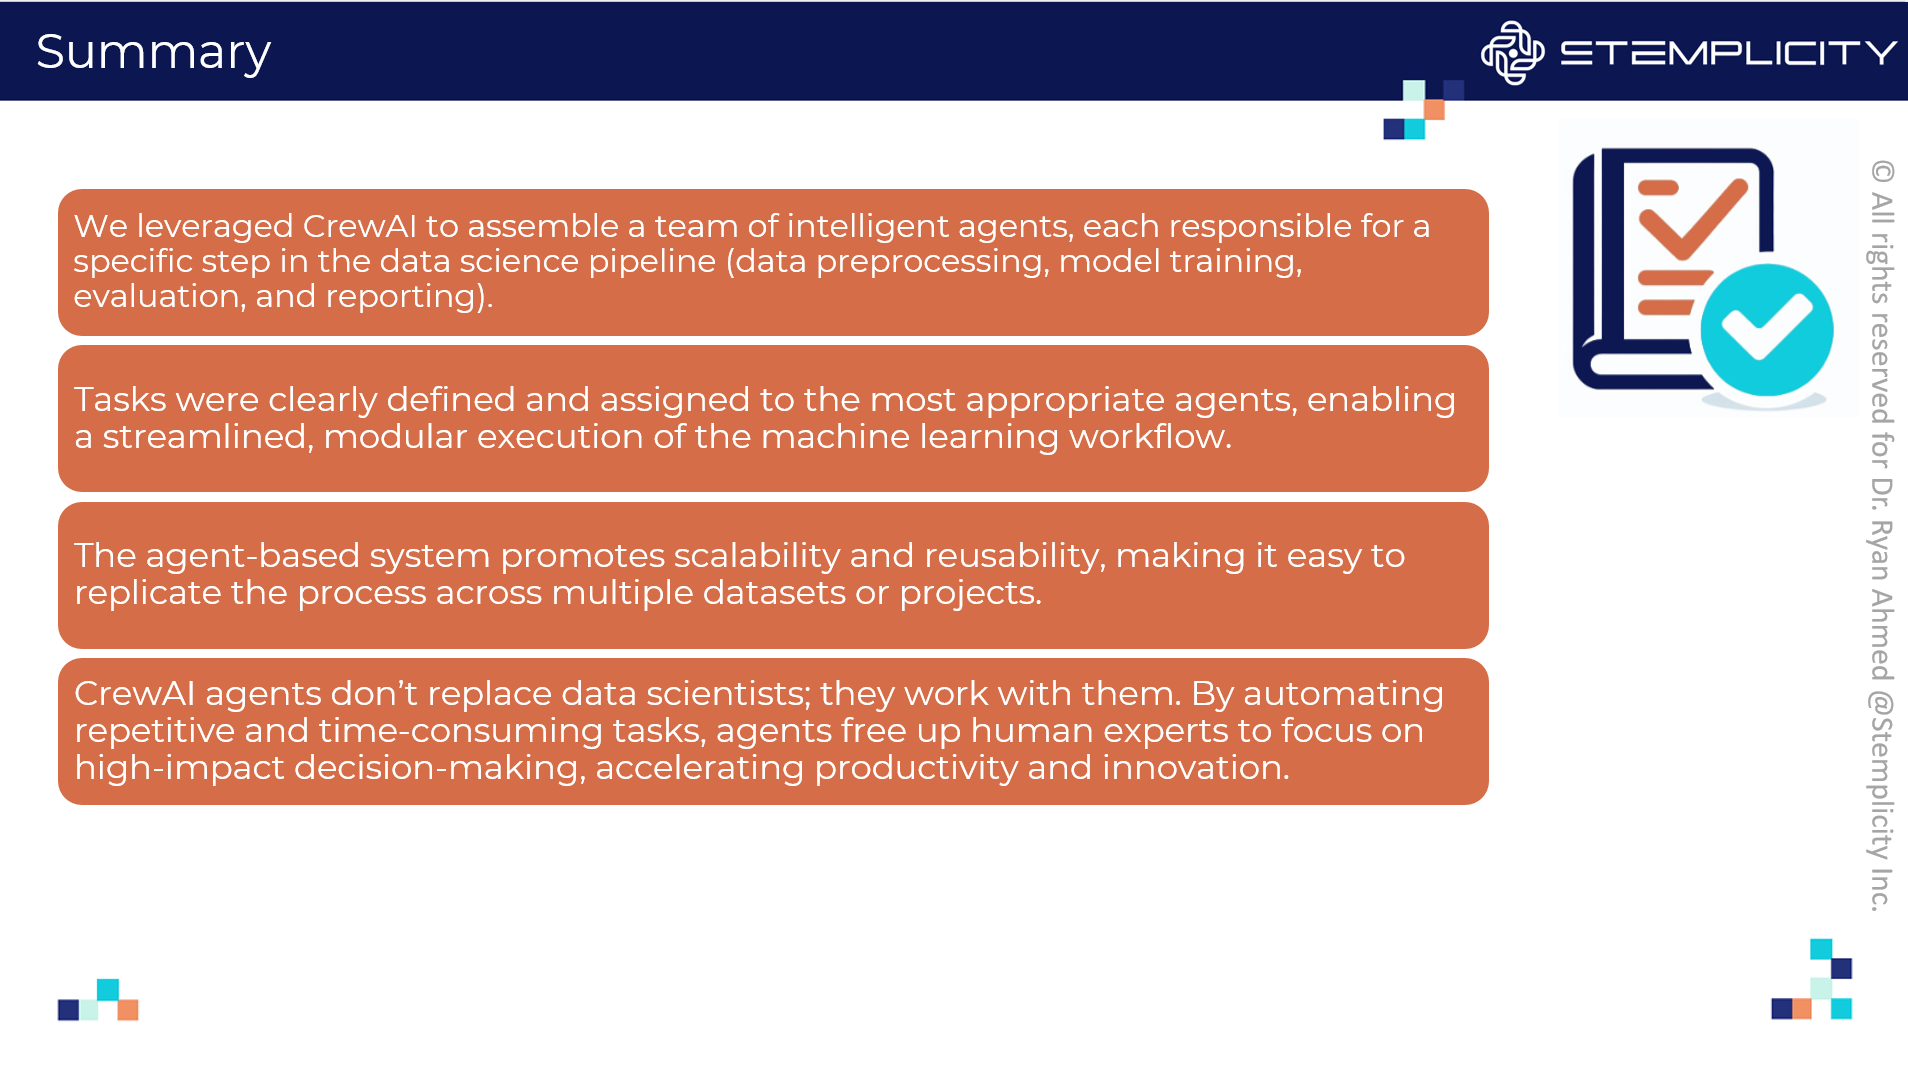

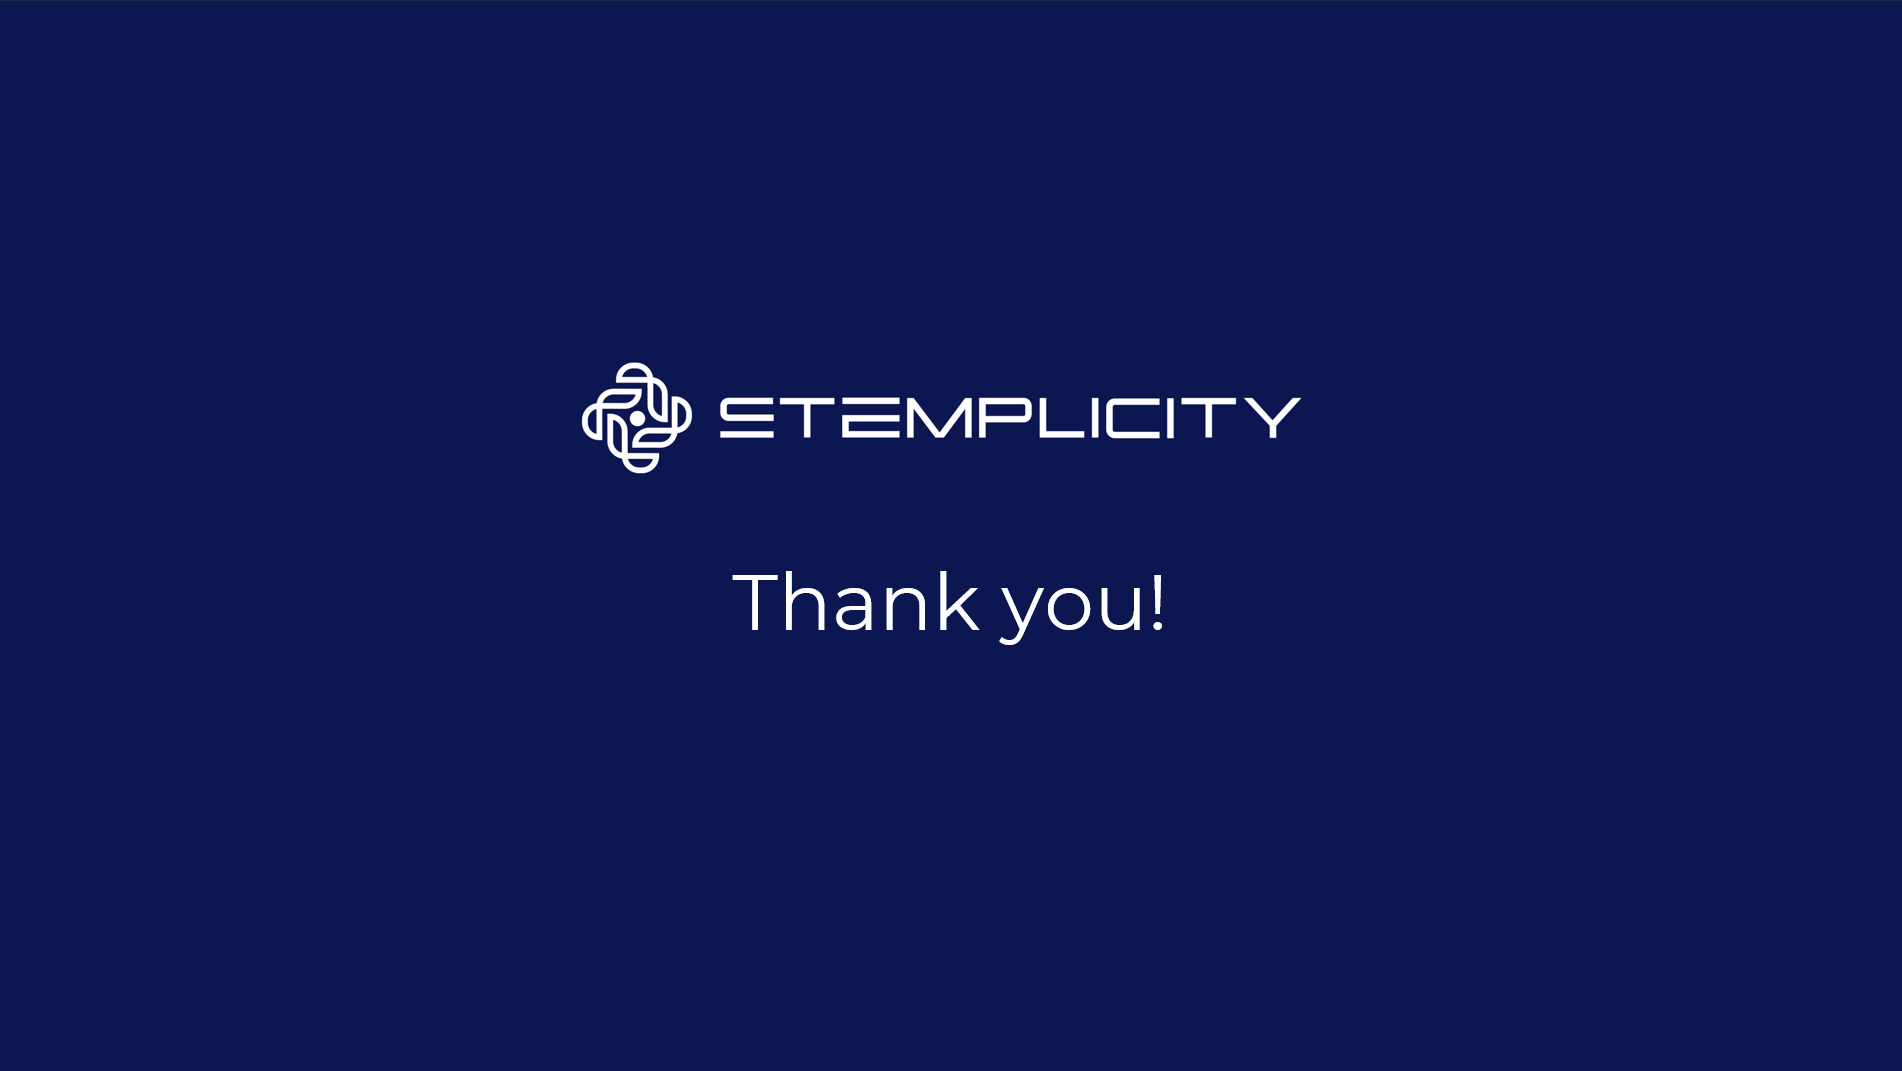